In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
_URL='https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
pathToZip=tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH=os.path.join(os.path.dirname(pathToZip), 'cats_and_dogs_filtered')

train_dir=os.path.join(PATH, 'train')
validation_dir=os.path.join(PATH, 'validation')

BATCH_SIZE=32
IMG_SIZE=(160, 160)

train_dataset=image_dataset_from_directory(train_dir,
                                           shuffle=True,
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset=image_dataset_from_directory(validation_dir,
                                                shuffle=True,
                                                batch_size=BATCH_SIZE,
                                                image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


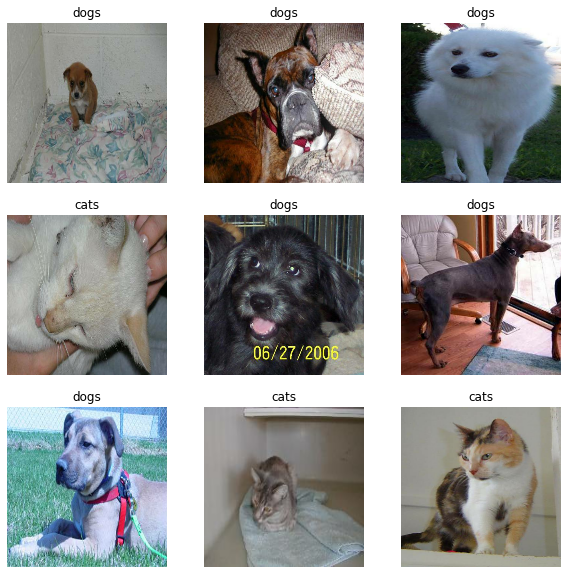

In [ ]:
class_names=train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_baches=tf.data.experimental.cardinality(validation_dataset)
test_dataset=validation_dataset.take(val_baches // 5)
validation_dataset=validation_dataset.skip(val_baches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
#Aumento de datos
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.RandomFlip('horizontal'),
                    tf.keras.layers.RandomRotation(0.2),                     
])

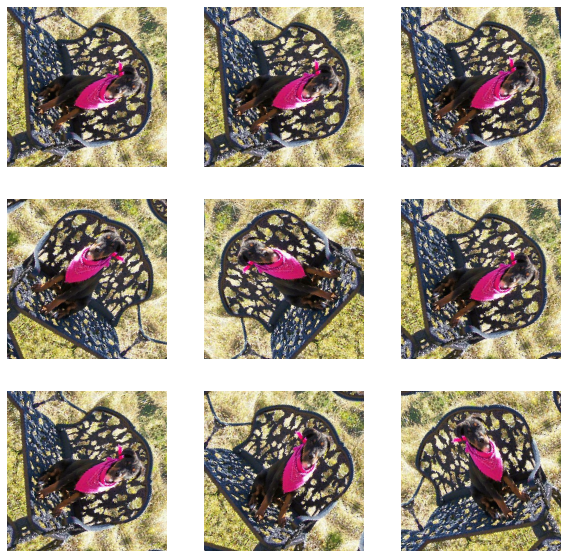

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    augmented_image=data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0]/255)
    plt.axis('off')

In [ ]:
#Cambiar escala pixeles

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
#Creacion del modelo
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
#Agregar encabezado de clasificacion
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#Compilacion del modelo
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
#Training model
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 14s 465ms/step - loss: 0.8097 - accuracy: 0.4740


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.81
initial accuracy: 0.47


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 51s 757ms/step - loss: 0.7463 - accuracy: 0.5330 - val_loss: 0.5668 - val_accuracy: 0.6399
Epoch 2/10
63/63 [==============================] - 48s 752ms/step - loss: 0.5636 - accuracy: 0.6835 - val_loss: 0.4160 - val_accuracy: 0.7525
Epoch 3/10
63/63 [==============================] - 48s 756ms/step - loss: 0.4551 - accuracy: 0.7610 - val_loss: 0.3136 - val_accuracy: 0.8403
Epoch 4/10
63/63 [==============================] - 48s 758ms/step - loss: 0.3817 - accuracy: 0.8095 - val_loss: 0.2593 - val_accuracy: 0.8874
Epoch 5/10
63/63 [==============================] - 48s 755ms/step - loss: 0.3371 - accuracy: 0.8450 - val_loss: 0.2163 - val_accuracy: 0.9134
Epoch 6/10
63/63 [==============================] - 48s 754ms/step - loss: 0.2942 - accuracy: 0.8625 - val_loss: 0.1934 - val_accuracy: 0.9196
Epoch 7/10
63/63 [==============================] - 48s 764ms/step - loss: 0.2664 - accuracy: 0.8830 - val_loss: 0.1679 - val_accuracy: 0.9295

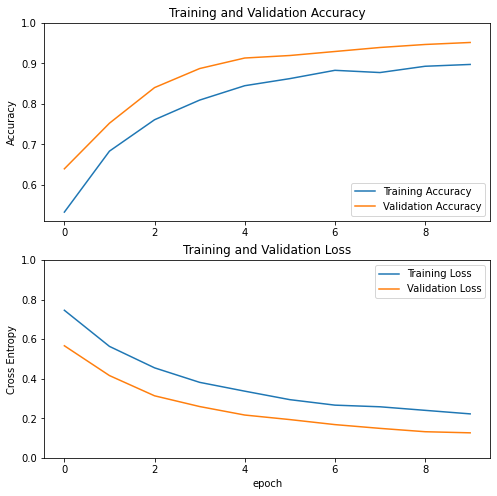

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Capas superiores modelo
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#Compilacion modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

56

In [ ]:
#Continuacion entrenamiento del modelo
fine_tune_epochs = 10
total_epochs = initial_epochs +fine_tune_epochs
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 85s 1s/step - loss: 0.1545 - accuracy: 0.9390 - val_loss: 0.0452 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 72s 1s/step - loss: 0.1154 - accuracy: 0.9560 - val_loss: 0.0416 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 72s 1s/step - loss: 0.1154 - accuracy: 0.9545 - val_loss: 0.0529 - val_accuracy: 0.9740
Epoch 13/20
63/63 [==============================] - 71s 1s/step - loss: 0.0998 - accuracy: 0.9560 - val_loss: 0.0566 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 72s 1s/step - loss: 0.0843 - accuracy: 0.9580 - val_loss: 0.0394 - val_accuracy: 0.9889
Epoch 15/20
63/63 [==============================] - 71s 1s/step - loss: 0.0735 - accuracy: 0.9655 - val_loss: 0.0343 - val_accuracy: 0.9901
Epoch 16/20
63/63 [==============================] - 71s 1s/step - loss: 0.0672 - accuracy: 0.9765 - val_loss: 0.0367 - val_accuracy: 0.9864
Epoch 17/20
6

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

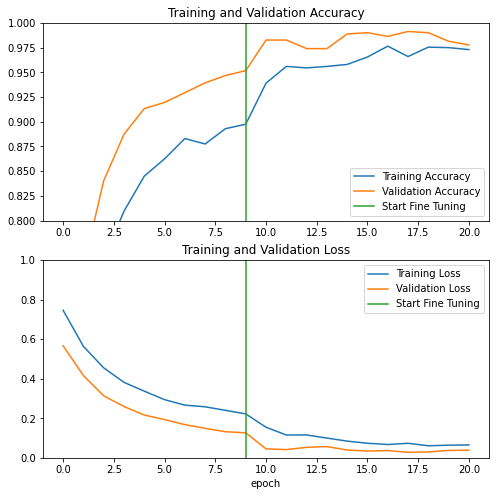

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
#Evaluacion y prediccion
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 3s 472ms/step - loss: 0.0524 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1]
Labals:
 [0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 1]


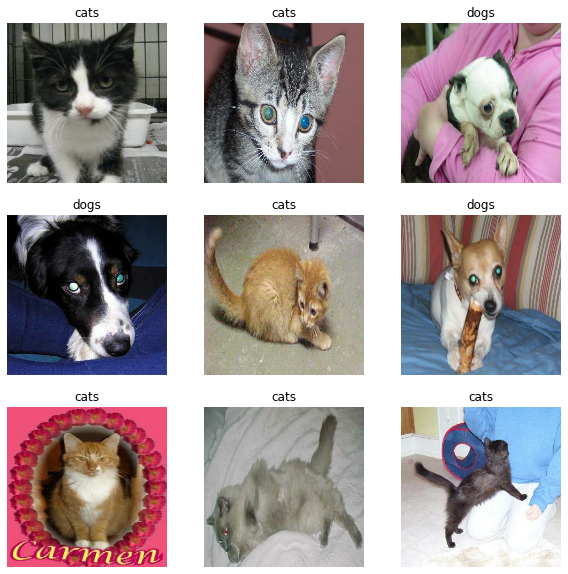

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labals:\n', label_batch)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")